In [41]:
"""LiuKatrina_10.ipynb Harvard MCB 112 Problem Set 10: the adventure of moonlighting genes submitted by Xiao (Katrina) Liu"""
__author__      = "Katrina Liu"
__email__ = "xliu@hms.harvard.edu"
__date__ = "Nov 12, 2022"

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

# Exercise 1: Positive Control
The procedures of the generative model for NMF can be described as follows:
- Initialize weights $W$. Row: Gene (N) X Col: Module (R)
    - Determine if each gene is hybrid.
    - Assign each gene to the modules. 
    - Randomize and renormalize the exeach column for each module.
- Initialize mixture coefficients $H$. Row: Module (R) X Col: Sample (M)
    - Generate a ones matrix.
    - Apply direichlet along each column.
- Calculate expected count matrix $\lambda = CWH$, where $C= 1e6$ in this case.
- Calculate generated count matrix $V$.
    - Add Poisson noise to $\lambda$.

In [43]:
def get_weights(N,R,hybrid_percent=0.2):
    """
    Generate a weight/relative expression level matrix
    :param N: number of genes
    :param R: number of modules
    :param hybrid_percent: percentage of moonlight genes
    :return: a NxR 2d-numpy array of relative expression level matrix
    """
    W = np.zeros((N,R))
    for i in range(N):
        hybrid = np.random.choice(2,p=[1-hybrid_percent,hybrid_percent])
        if hybrid == 0:
            mod = np.random.randint(0,R)
            W[i][mod] = 1
        else:
            num_mods = np.random.randint(2,R+1)
            mods = np.random.permutation(R)[:num_mods]
            W[i,mods] = 1
    for i in range(R):
        col = W[:,i]
        one_id = np.argwhere(col != 0)
        expr = np.random.dirichlet(np.ones(len(one_id)))
        for j in range(len(one_id)):
            W[one_id[j],i] = expr[j]
    return W

def get_mixture_coefficients(R,M):
    """
    Generate a mixture coefficient matrix
    :param R: number of modules
    :param M: number of samples
    :return: an RxM 2d-array of mixture coefficient matrix
    """
    H = np.ones((R,M))
    return np.apply_along_axis(np.random.dirichlet, 0, H)

def generate_NMF_count(N,R,M):
    """
    Generate a gene expression level matrix with Poisson noise
    :param N: number of genes
    :param R: number of modules
    :param M: number of samples
    :return: an NxM 2d-numpy array of simulated gene counts
    """
    W = get_weights(N,R)
    H = get_mixture_coefficients(R,M)
    C = 1e6
    lbd = C*np.dot(W,H)
    return W, H, np.random.poisson(lbd)


In [44]:
# Simulate one example with R=4
N_gen = 100
R_gen = 4
M_gen = 60
W_gen, H_gen, V_gen = generate_NMF_count(N_gen,R_gen,M_gen)


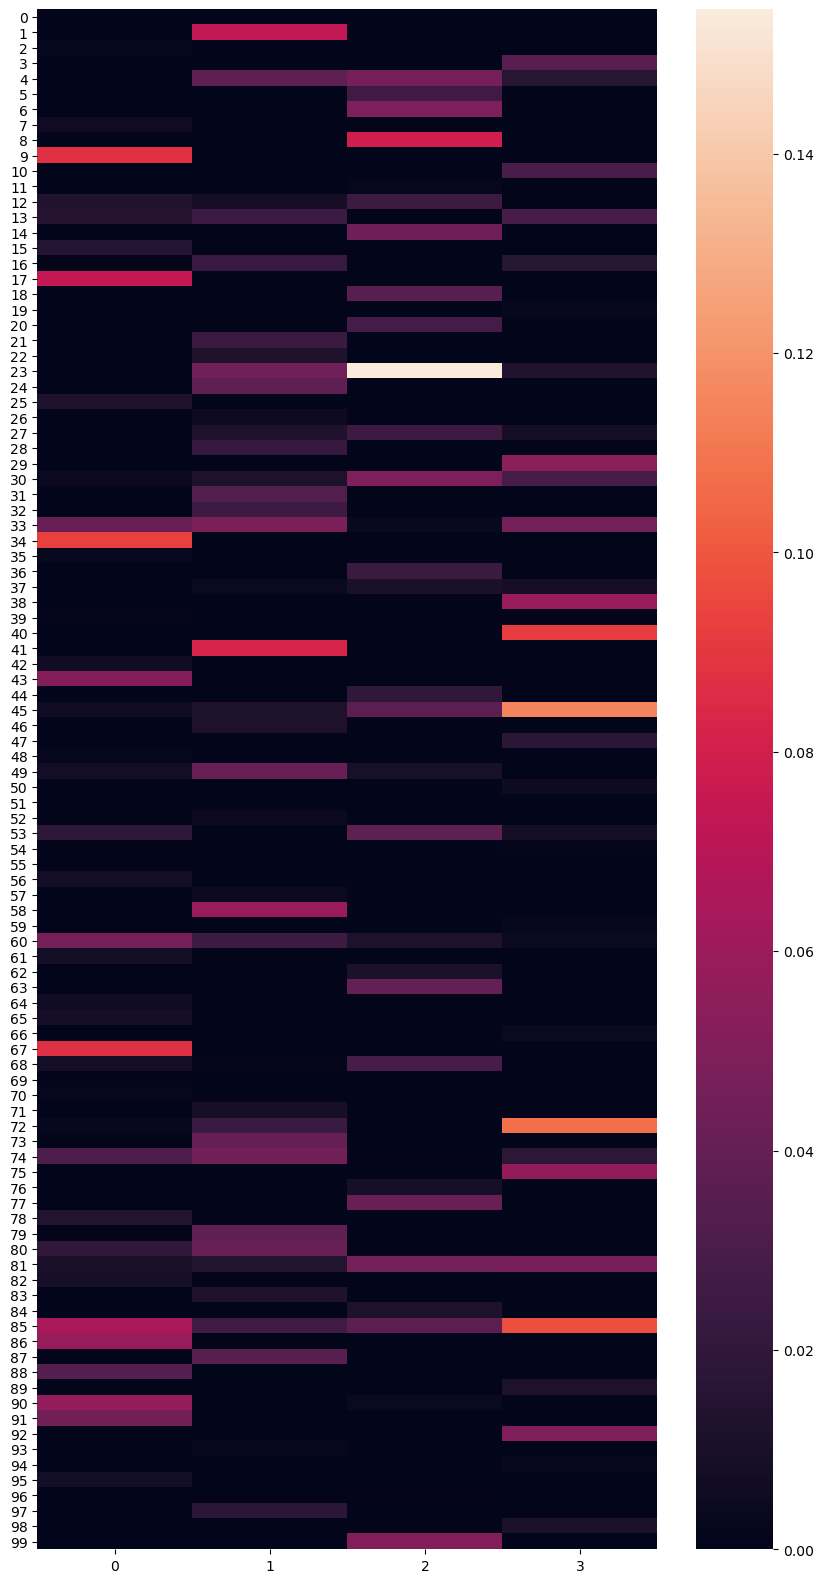

In [45]:
# Visualization the relative expression level
plt.figure(figsize=(10,20))
sns.heatmap(W_gen)
plt.show()

**Justification of Reasonable Data**: The above heatmap plots the distribution of the relative expression levels of genes. Each column sums up to one and the distribution is sparse with most gene only belongs to one group and the remaining ones are hybrid. Therefore, the data we generated is reasonable.

# Exercise 2: Non-negative Matrix Factorization 
We begin with the basic calculate and update for total counts $C$ and expected counts $\lambda$. We use equations from section notes from [mcb112.org](mcb112.org).
$$\sum_{i}V_{i\mu} = C_{\mu}$$
$$\lambda_{i\mu} = C_{\mu}(WH)$$

In [46]:
def calculate_C(V):
    """
    Calculate total counts from observed counts
    :param V: an NxM 2d-numpy array of observed gene counts
    :return: a numpy array of length M of total counts of each sample
    """
    return V.sum(axis=0)

def calculate_lambda(C,W,H):
    """
    Calculate expected counts
    :param C: a numpy array of length M of total counts of each sample
    :param W: a NxR 2d-numpy array of relative expression level matrix
    :param H: an RxM 2d-array of mixture coefficient matrix
    :return: an NxM 2d-numpy array of expected count
    """
    return C*np.dot(W,H)

$$\log P(V|W,H) = \sum_{\mu}\sum_{i} (V_{i\mu}\log \lambda_{i\mu}-\lambda_{i\mu}-\log (V_{i\mu}!))$$
We simplify the objective by ignoring the factorial of observed counts. The reason we can do this is because it does not change with differen parameters, so the term is constant through out different parameters and therefore does not contribute to the calculation of differences in log likelihood. Therefore, our new objective can be simplified into $$Objective = \log P(V|W,H) = \sum_{\mu}\sum_{i} (V_{i\mu}\log \lambda_{i\mu}-\lambda_{i\mu}) = \sum_{i}\sum_{\mu}(V\log lambda - \lambda)$$

In [47]:
def log_likelihood(V,V_exp):
    """
    Calculate the log likelihood objective of the observed count
    :param V: an NxM 2d-numpy array of observed gene counts
    :param V_exp: an NxM 2d-numpy array of expected count
    :return: the log likelihood objective of observing the counts given the expected count
    """
    return np.sum(V*np.log(V_exp)-V_exp)

To perform gradient ascent, we will update W and H gradually following the below formula:
$$W_{ia}' = W_{ia}(\sum_{\mu}(\dfrac{V_{i\mu}}{\lambda_{i\mu}}C_{\mu}H_{a\mu}))$$
$$W_{ia}'' = \dfrac{W'_{ia}}{\sum_{ja}W'_{ja}}$$
$$H_{a\mu}' = H_{a\mu}(\sum_{i}\dfrac{V_{i\mu}}{\lambda_{i\mu}}W_{ia})$$

In [48]:

def update(W,H,V_obs,V_exp,C):
    """
    Gradient update W and H
    :param W: a NxR 2d-numpy array of relative expression level matrix
    :param H: an RxM 2d-array of mixture coefficient matrix
    :param V_obs: an NxM 2d-numpy array of observed gene counts
    :param V_exp: an NxM 2d-numpy array of expected count
    :param C: a numpy array of length M of total counts of each sample
    :return: the upated NxR weight matrix, the updated RxM coefficient matrix
    """
    W_prime = W*(np.dot((C*V_obs)/V_exp,H.T))
    W_prime = W_prime/np.sum(W_prime,axis=0)
    H_prime = H*np.dot(W.T,V_obs/V_exp)
    return W_prime, H_prime


In [49]:
def gradient_ascent(V_obs, R, stop_diff=0.001, iter=5):
    """
    Gradient Ascent Optimization of NMF
    :param V_obs: an NxM 2d-numpy array of observed gene counts
    :param R: number of modules
    :param stop_diff: stop criterion thresholding the change in objective
    :param iter: number of iteration to run NMF to avoid stuck in local maximum
    :return:
    """
    N,M = V_obs.shape
    W_max, H_max, lls_max = [],[],[0]
    for _ in range(iter):
        # Random initialization
        W = np.random.dirichlet(np.ones(N),R).T
        H = np.random.dirichlet(np.ones(R),M).T
        C = calculate_C(V_obs)
        V_exp = calculate_lambda(C,W,H)
        ll = log_likelihood(V_obs, V_exp)
        prev_ll = None
        lls = [ll]
        while prev_ll is None or abs(ll-prev_ll)>stop_diff:
            prev_ll = ll
            W,H = update(W,H,V_obs,V_exp,C)
            V_exp = calculate_lambda(C,W,H)
            ll = log_likelihood(V_obs,V_exp)
            lls.append(ll)
        if lls[-1] > lls_max[-1]:
            W_max,H_max, lls_max = W,H,lls
    return W_max,H_max,lls_max

# Exercise 3: Test on Positive Control
To test our data on positive control data we generated in exercise 1, we will try all possible values for number of modules and see what number fits the best.

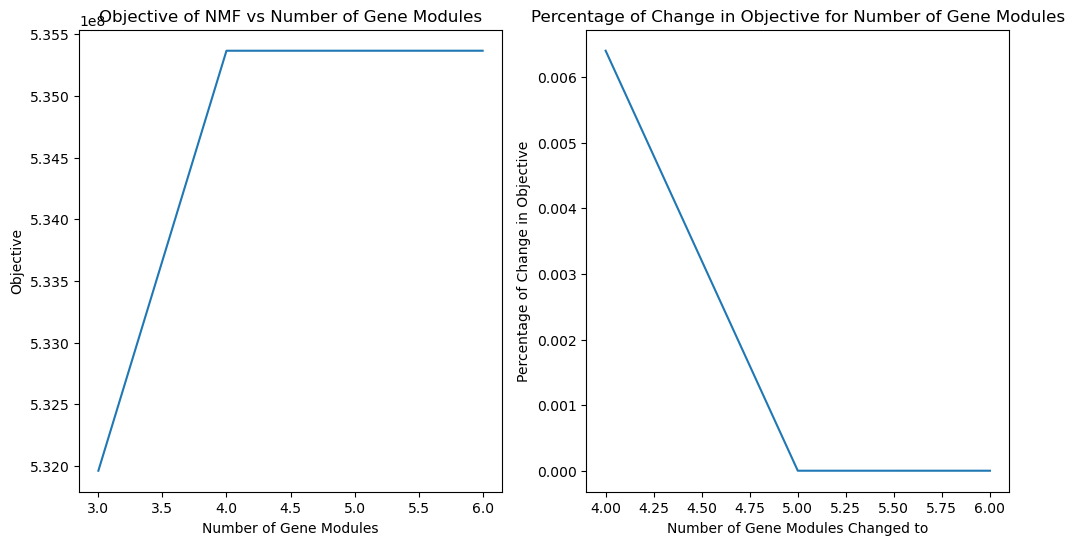

In [50]:
# Test on previously generated data
lls_r = []
for r in range(3,7):
    W_grad,H_grad,lls_grad = gradient_ascent(V_gen,r)
    lls_r.append(lls_grad[-1])
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(range(3,7), lls_r)
plt.title("Objective of NMF vs Number of Gene Modules")
plt.xlabel("Number of Gene Modules")
plt.ylabel("Objective")
plt.subplot(122)

plt.plot(range(4,7), [(lls_r[i+1]-lls_r[i])/lls_r[i] for i in range(3)])
plt.title("Percentage of Change in Objective for Number of Gene Modules")
plt.xlabel("Number of Gene Modules Changed to")
plt.ylabel("Percentage of Change in Objective")
plt.show()

We see that the objective increase minimally at R=4, which implies that R=4 is the smallest best guess for number of modules. One might argue that the objective is still greater when R=5 than when R=4, but we see that the increase percentage is minimum and the fact that if the genes can be fitted into 4 gene modules, they can achieved the same performance by samply being fitted into 5 modules with one almost empty. Therefore, a reasonable assumption in guessing the true number of modules can be infered from the percentage of changes between the objective at different number of modules. In conclusion, from the result of the model, we can successfully infer the correct number of modules.

To evaluate the correctness of results of NMF further, we want to test on generated data with different number of modules.

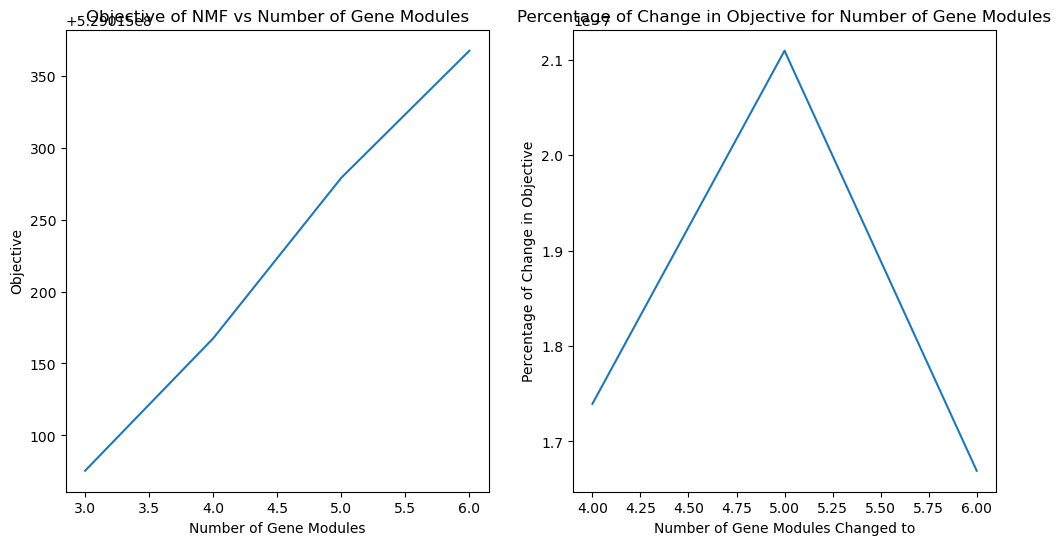

In [51]:
# Test 1 R=3
N_test1 = 100
R_test1 = 3
M_test1 = 60
W_test1, H_test1, V_test1 = generate_NMF_count(N_test1,R_test1,M_test1)
lls_r_test1 = []
for r in range(3,7):
    W_grad,H_grad,lls_grad = gradient_ascent(V_test1,r)
    lls_r_test1.append(lls_grad[-1])
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(range(3,7), lls_r_test1)
plt.title("Objective of NMF vs Number of Gene Modules")
plt.xlabel("Number of Gene Modules")
plt.ylabel("Objective")
plt.subplot(122)
plt.plot(range(4,7),[(lls_r_test1[i+1]-lls_r_test1[i])/lls_r_test1[i] for i in range(3)])
plt.title("Percentage of Change in Objective for Number of Gene Modules")
plt.xlabel("Number of Gene Modules Changed to")
plt.ylabel("Percentage of Change in Objective")
plt.show()

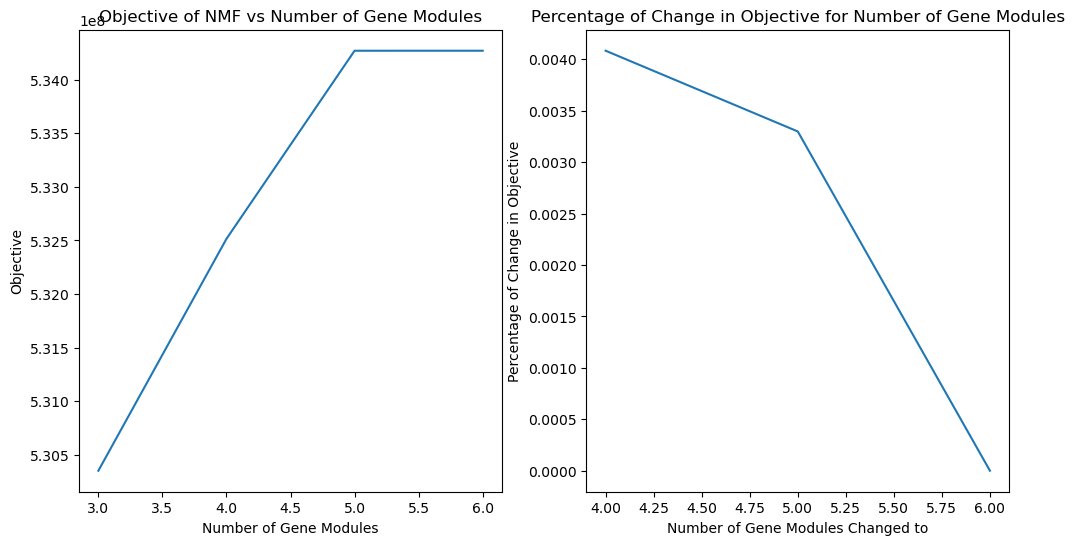

In [52]:
# Test 2 R=5
N_test2 = 100
R_test2 = 5
M_test2 = 60
W_test2, H_test2, V_test2 = generate_NMF_count(N_test2,R_test2,M_test2)
lls_r_test2 = []
for r in range(3,7):
    W_grad,H_grad,lls_grad = gradient_ascent(V_test2,r)
    lls_r_test2.append(lls_grad[-1])
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(range(3,7), lls_r_test2)
plt.title("Objective of NMF vs Number of Gene Modules")
plt.xlabel("Number of Gene Modules")
plt.ylabel("Objective")
plt.subplot(122)
plt.plot(range(4,7),[(lls_r_test2[i+1]-lls_r_test2[i])/lls_r_test2[i] for i in range(3)])
plt.title("Percentage of Change in Objective for Number of Gene Modules")
plt.xlabel("Number of Gene Modules Changed to")
plt.ylabel("Percentage of Change in Objective")
plt.show()

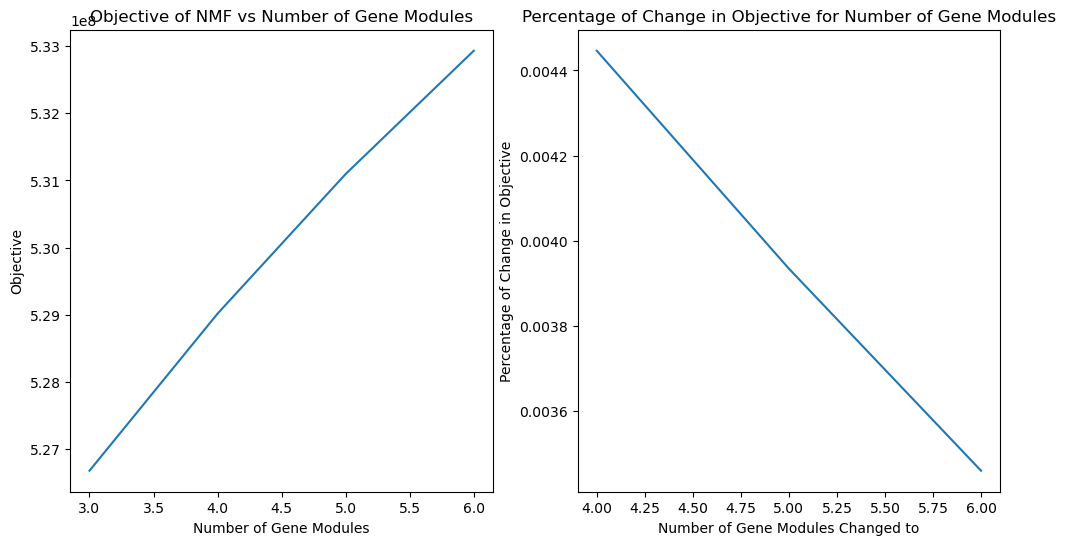

In [53]:
# Test 3 R=6
N_test3 = 100
R_test3 = 6
M_test3 = 60
W_test3, H_test3, V_test3 = generate_NMF_count(N_test3,R_test3,M_test3)
lls_r_test3 = []
for r in range(3,7):
    W_grad,H_grad,lls_grad = gradient_ascent(V_test3,r)
    lls_r_test3.append(lls_grad[-1])
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(range(3,7), lls_r_test3)
plt.title("Objective of NMF vs Number of Gene Modules")
plt.xlabel("Number of Gene Modules")
plt.ylabel("Objective")
plt.subplot(122)
plt.plot(range(4,7),[(lls_r_test3[i+1]-lls_r_test3[i])/lls_r_test3[i] for i in range(3)])
plt.title("Percentage of Change in Objective for Number of Gene Modules")
plt.xlabel("Number of Gene Modules Changed to")
plt.ylabel("Percentage of Change in Objective")
plt.show()

We see that, if the percentage of change is very small (at the level of 1e7), we can conclude savely that we should not increase our guess of number of modules. If the percentage of change is relatively large (at the level of 1e3), we should make the increase step for the optimal guess of number of modules. Our interpretation shows that our NMF model works well.

# Exercise 4: Adler's data
We begin by loading the data table file.

In [54]:
def get_data(filename):
    """
    Read datatable file
    :param filename: path to data table file
    :return: a pandas data frame of gene expressions
    """
    return pd.read_csv(filename,delim_whitespace=True,header=None,index_col=0)

In [55]:
# Read adler's data
adler_data = get_data("w10-data.tbl")
adler_data

,1,2,3,4,5,6,7,8,9,10,...,51,52,53,54,55,56,57,58,59,60
0,,,,,,,,,,,,,,,,,,,,,
anise,1001,202,327,608,176,237,285,440,926,86,...,476,1095,77,909,1123,148,540,61,976,185
apricot,565,1061,182,531,224,999,1019,1109,562,233,...,376,132,452,550,621,1386,1625,93,169,247
artichoke,1950,3851,639,2010,840,3798,3630,3893,2019,848,...,1453,509,1554,1999,2256,4906,5662,292,580,847
arugula,1175,2648,384,1369,531,2367,2346,2492,1320,505,...,877,278,984,1256,1502,3143,3679,213,372,546
asparagus,1368,4152,415,707,6866,372,2326,1241,562,2187,...,1539,2285,3376,3123,1667,3304,696,683,4332,6990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wasabi,81,261,25,50,406,20,135,77,31,128,...,83,143,217,217,95,210,46,45,266,449
watercress,89,72,444,281,120,365,177,251,226,364,...,269,78,238,68,34,19,63,511,81,29
watermelon,679,2083,180,330,3463,174,1097,563,266,1085,...,718,1103,1732,1554,843,1625,332,350,2141,3412


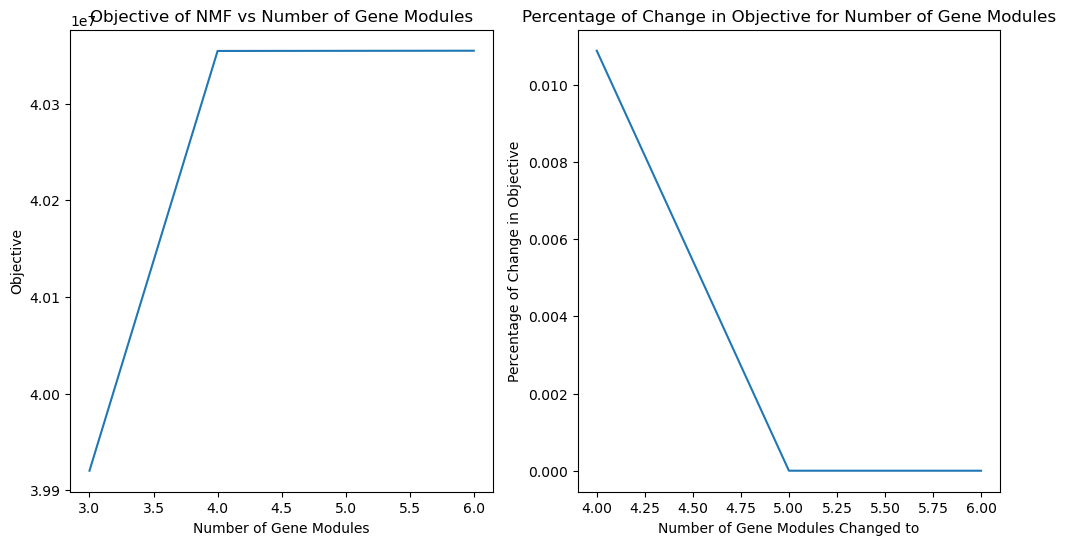

In [56]:
# Preprocess data into np matrix
N_adler,M_alder = adler_data.shape
data = np.array(adler_data)

# Obtain NMF results of adler's data 
lls_adler_r = []
for r in range(3,7):
    W_adler, H_adler ,lls_adler = gradient_ascent(data,r)
    lls_adler_r.append(lls_adler[-1])
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(range(3,7), lls_adler_r)
plt.title("Objective of NMF vs Number of Gene Modules")
plt.xlabel("Number of Gene Modules")
plt.ylabel("Objective")
plt.subplot(122)
plt.plot(range(4,7),[(lls_adler_r[i+1]-lls_adler_r[i])/lls_adler_r[i] for i in range(3)])
plt.title("Percentage of Change in Objective for Number of Gene Modules")
plt.xlabel("Number of Gene Modules Changed to")
plt.ylabel("Percentage of Change in Objective")
plt.show()

We can see that the optimal number of gene modules is 4. The reasoning follows what we have concluded in Exercise 3, where we see that the objective converges at 4 modules with minimal changes and therefore we can determine the most likely modules is 4.

We will obtain the W matrix from NMF to determine actual membership of genes to each gene module.

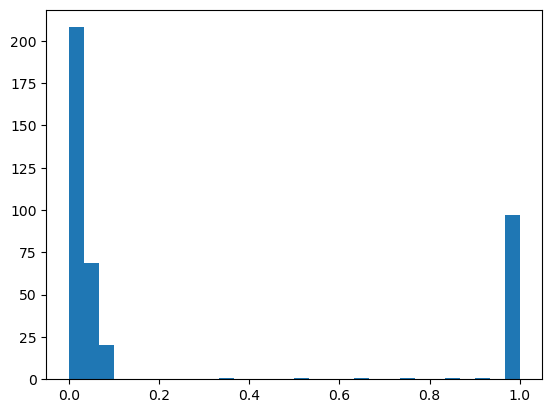

In [57]:
# Parameters when R=4
W_adler, H_adler, lls_adler = gradient_ascent(data, 4)

# Normalize each row to emphasize the difference of expression levels
W_normed = normalize(W_adler, axis=1)
plt.figure()
plt.hist(W_normed.flatten(), bins=30)
plt.show()

Therefore, a reasonable threshold could be 0.15 as it separates most of the smaller values.

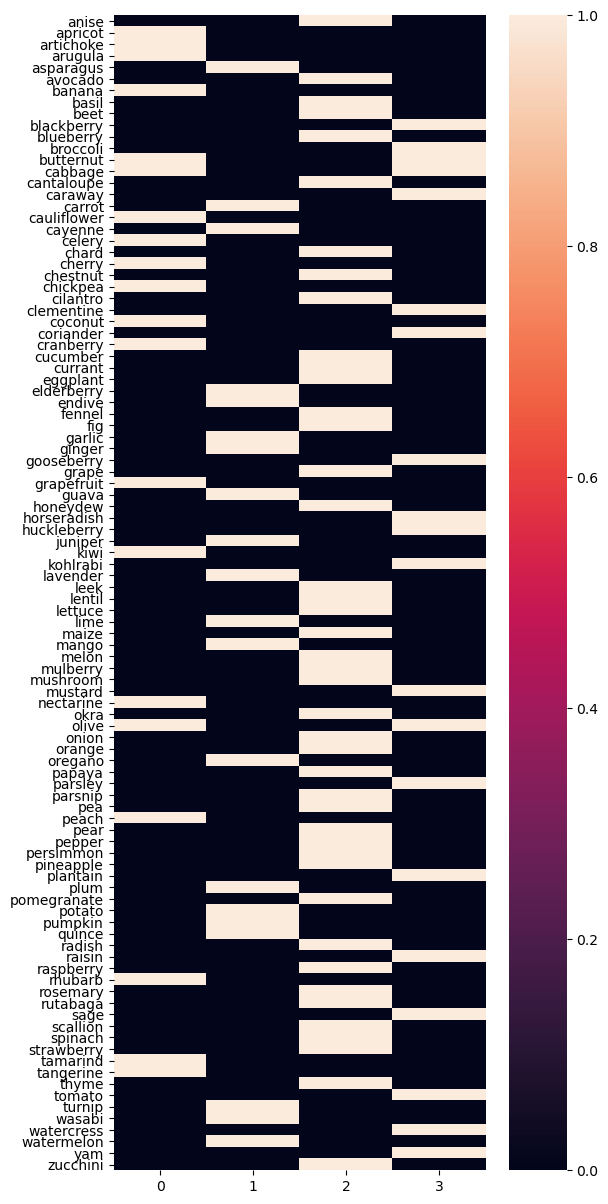

In [58]:
# Thresholding the expression level to find membership
threshold = 0.15
W_infered = W_normed>threshold

# Plot the membership
plt.figure(figsize=(6,15))
sns.heatmap(W_infered, yticklabels=adler_data.index)
plt.show()


In [59]:
# Output the resulting module information
gene_mod_count = W_infered.sum(axis=0)
for i in range(4):
    W_infer_col = W_infered[:,i]
    genes = adler_data.index[W_infer_col == 1]
    print("Module %d has %d genes: %s" %(i, len(genes), " ".join(genes)))

# Output moonlight gene information
moonlight = W_infered.sum(axis=1)>1
moonlight_genes = adler_data.index[moonlight==True]
print("There are %d moonlight genes: %s" %(len(moonlight_genes), " ".join(moonlight_genes)))

Module 0 has 20 genes: apricot artichoke arugula banana butternut cabbage cauliflower celery cherry chickpea coconut cranberry grapefruit kiwi nectarine olive peach rhubarb tamarind tangerine
Module 1 has 20 genes: asparagus carrot cayenne elderberry endive garlic ginger guava juniper lavender lime mango oregano plum potato pumpkin quince turnip wasabi watermelon
Module 2 has 43 genes: anise avocado basil beet blueberry cantaloupe chard chestnut cilantro cucumber currant eggplant fennel fig grape honeydew leek lentil lettuce maize melon mulberry mushroom okra onion orange papaya parsnip pea pear pepper persimmon pineapple pomegranate radish raspberry rosemary rutabaga scallion spinach strawberry thyme zucchini
Module 3 has 20 genes: blackberry broccoli butternut cabbage caraway clementine coriander gooseberry horseradish huckleberry kohlrabi mustard olive parsley plantain raisin sage tomato watercress yam
There are 3 moonlight genes: butternut cabbage olive
